In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot
import seaborn as sns
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.utils import to_categorical
import pickle
import os
import NN

import dataset_utils
import importlib
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import LinearLocator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Conv3D, MaxPooling3D, Embedding, LSTM, Bidirectional, Reshape, Concatenate

In [24]:
DATA_DIR = "cluster_data/sd_3_class_data/"
NUM_POINTS = 100
NUM_CLASSES = 3
BATCH_SIZE = 32
train_points, test_points, train_labels, test_labels, CLASS_MAP = dataset_utils.parse_dataset(NUM_POINTS, DATA_DIR)

processing class: jumping
processing class: speed_walking
processing class: walking


In [23]:
print(train_points.shape)

(0,)


In [25]:
def ConvBlock(x, filters, kernel_size=1, stride=1, padding='valid'):
    """Convolutional Block with Batch Normalization and ReLU activation."""
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

In [29]:

# Input layer for point cloud data

input_shape = (NUM_POINTS, 5)
num_classes = NUM_CLASSES
inputs = layers.Input(shape=input_shape)

# Expand dimensions for point-wise convolution
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))(inputs)

# Convolutional Layers
x = ConvBlock(x, filters=64, kernel_size=(1, input_shape[1]))
x = ConvBlock(x, filters=128, kernel_size=(1, 1))
x = ConvBlock(x, filters=256, kernel_size=(1, 1))

# Global Feature Aggregation
x = layers.GlobalMaxPooling2D()(x)

# Fully connected layers for classification
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)

# Output layer with softmax for classification
outputs = layers.Dense(num_classes, activation='softmax')(x)

# Build model
model = models.Model(inputs=inputs, outputs=outputs)



In [30]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100, 5)]          0         
                                                                 
 lambda_4 (Lambda)           (None, 100, 5, 1)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 100, 1, 64)        384       
                                                                 
 batch_normalization_12 (Ba  (None, 100, 1, 64)        256       
 tchNormalization)                                               
                                                                 
 re_lu_12 (ReLU)             (None, 100, 1, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 100, 1, 128)       8320      
                                                           

In [31]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
# training
history = model.fit(train_points, train_labels, epochs=30, validation_data=(test_points, test_labels), verbose=1, callbacks=[early_stopping])

Epoch 1/30


ValueError: in user code:

    File "c:\Users\cyber\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\cyber\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\cyber\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\cyber\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\cyber\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\cyber\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'model_4' (type Functional).
    
    Input 0 of layer "conv2d_12" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (32, 100, 1)
    
    Call arguments received by layer 'model_4' (type Functional):
      • inputs=tf.Tensor(shape=(32, 100), dtype=float32)
      • training=True
      • mask=None


In [15]:
test_loss, test_acc = model.evaluate(test_points, test_labels, verbose=1)

6/6 [==============================] - 0s 6ms/step - loss: 0.0265 - accuracy: 0.9939


6/6 [==============================] - 0s 6ms/step


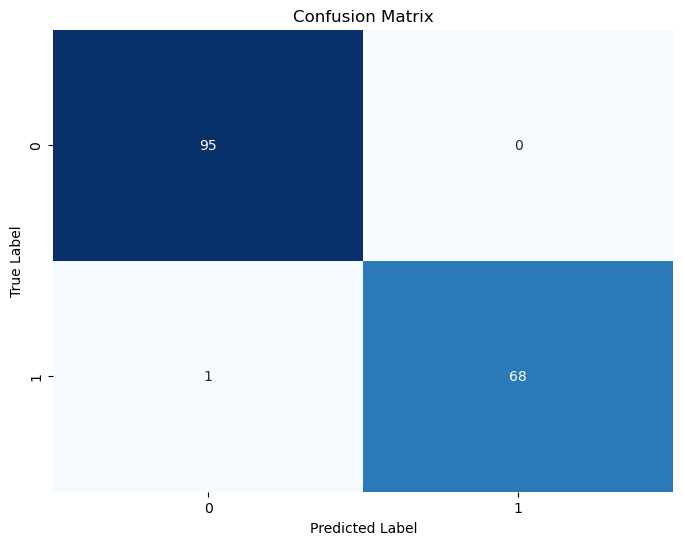

In [18]:
y_pred = np.argmax(model.predict(test_points), axis=1)

cm = tf.math.confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()